<a href="https://colab.research.google.com/github/eliseleahy/Pytorch-Tutorials/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Cunston Datasets

## 0. Importing Pytorch and setting up device agnostic code

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get some data

Dataset is a subset of Food101 dataset. (per image - 750 training, 250 test)

Dataset has only 3 classes adn only 10% of images (75 trainig, 25 testing)

In [ ]:
import requests
import zipfile
from pathlib import Path

# set up path to Datafolder

data_path = Path("data/")
image_path = data_path / "piz za_steak_sushi"

if image_path.is_dir():
  print("path doesn't exist")
else:
  image_path.mkdir(parents=True, exist_ok=True)

# download data

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading data")
  f.write(request.content)

#unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping data")
  zip_ref.extractall(image_path)

path doesn't exist
unzipping data


## 2. Data prepration and exploration

In [ ]:
import os

def walk_through_dir(dir_path):
  """ Walks through dir path returing its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} dir and {len(filenames)} images in '{dirpath}.")

In [ ]:
walk_through_dir(image_path)

There are 2 dir and 0 images in 'data/piz za_steak_sushi.
There are 3 dir and 0 images in 'data/piz za_steak_sushi/train.
There are 0 dir and 72 images in 'data/piz za_steak_sushi/train/sushi.
There are 0 dir and 75 images in 'data/piz za_steak_sushi/train/steak.
There are 0 dir and 78 images in 'data/piz za_steak_sushi/train/pizza.
There are 3 dir and 0 images in 'data/piz za_steak_sushi/test.
There are 0 dir and 31 images in 'data/piz za_steak_sushi/test/sushi.
There are 0 dir and 19 images in 'data/piz za_steak_sushi/test/steak.
There are 0 dir and 25 images in 'data/piz za_steak_sushi/test/pizza.


In [ ]:
# Setup traing and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/piz za_steak_sushi/train'),
 PosixPath('data/piz za_steak_sushi/test'))

## 2.1 visualise an image

write some code to
1. get all the image path,
2. chosse a random image path,
3. get class name pathlib.Path.parent.stem
4. open image with PIL (pillow)
5. show image and print meta data


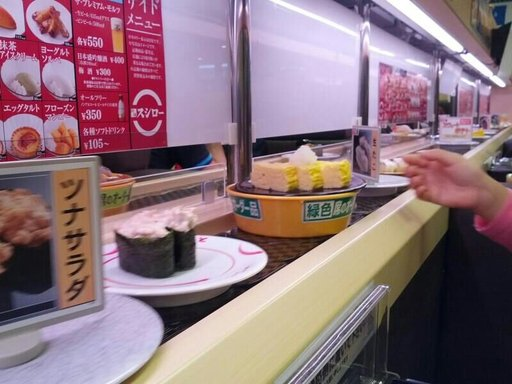

In [ ]:
import random
from PIL import Image

#set seed
#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
random_image_path

image_class = random_image_path.parent.stem
image_class

img=Image.open(random_image_path)
img

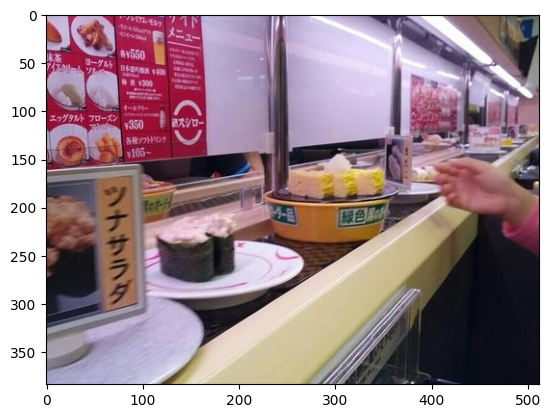

In [ ]:
#2 visulise some images
import matplotlib.pyplot as plt

image = plt.imread(random_image_path)

plt.imshow(image)



In [ ]:
import numpy as np

img_as_array = np.asarray(img)
img_as_array

array([[[195, 173, 212],
        [197, 176, 215],
        [201, 180, 219],
        ...,
        [ 34,  42,  45],
        [ 34,  41,  47],
        [ 36,  43,  49]],

       [[191, 174, 210],
        [192, 175, 211],
        [193, 177, 213],
        ...,
        [ 60,  68,  71],
        [ 63,  71,  74],
        [ 67,  75,  78]],

       [[192, 181, 211],
        [190, 179, 209],
        [189, 178, 210],
        ...,
        [ 86,  94,  96],
        [ 93,  98, 101],
        [ 97, 102, 105]],

       ...,

       [[167, 163, 198],
        [164, 160, 195],
        [161, 157, 192],
        ...,
        [ 14,  14,  26],
        [ 14,  14,  26],
        [ 14,  14,  26]],

       [[162, 158, 193],
        [161, 157, 192],
        [161, 157, 192],
        ...,
        [ 14,  14,  26],
        [ 14,  14,  26],
        [ 14,  14,  26]],

       [[167, 163, 198],
        [168, 164, 199],
        [171, 167, 202],
        ...,
        [ 14,  14,  26],
        [ 14,  14,  26],
        [ 15,  15,  27]]

##  3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (numerical representation of image)
2. Turn it into a 'torch.utils.data.Dataset' and subsequently a 'torch.utils.data.DataLoader'


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## 3.1 transforing data with torrchvission.transforms

In [ ]:
# write a transform for image
data_transform = transforms.Compose({
    #Resixe images to (64, 64)
    transforms.Resize(size=(64,64)),
    # flip images randomly on Hoz
    transforms.RandomHorizontalFlip(p=0.5),
    #turn th image into a torch tensor
    transforms.ToTensor()
})

In [ ]:
data_transform(img).dtype

torch.float32

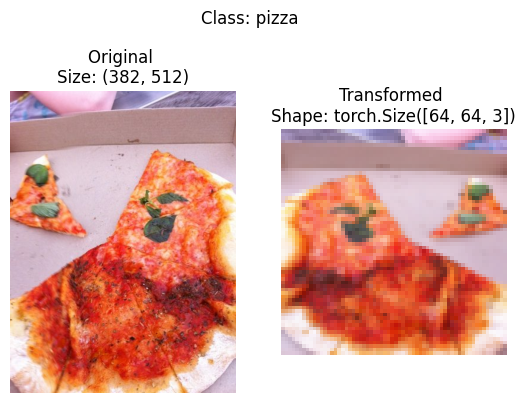

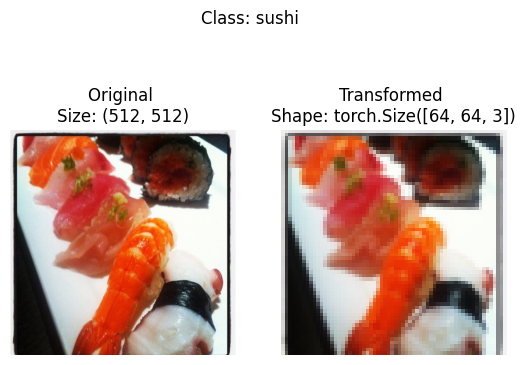

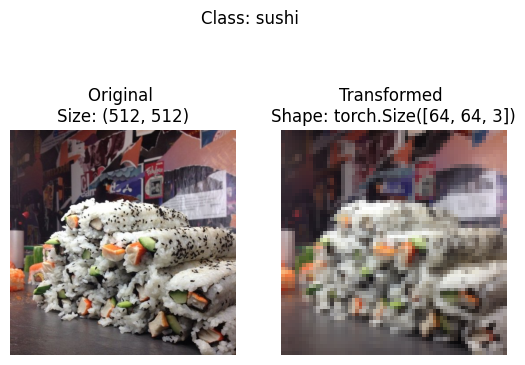

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """ selects random images and transforms image and plot original vs transofrmed image """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      #Transfom image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}")

plot_transformed_images(image_path_list, data_transform, n=3)

##4. Option 1: Loading image data using ImageFolder

we can load image classisication data using torchvision.datasets.ImageFolder


In [ ]:
#Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform, # transform for the data
                                 target_transform=None # transform for the label/target
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform, # transform for the data
                                 )

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/piz za_steak_sushi/train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/piz za_steak_sushi/test
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# get class names as dict

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Index on the train_data Dataset to gte image and label

img, label = train_data[9][0], train_data[9][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
tensor([[[0.1255, 0.1725, 0.1647,  ..., 0.8157, 0.6863, 0.6275],
         [0.1020, 0.1882, 0.1686,  ..., 0.3373, 0.4510, 0.6667],
         [0.0941, 0.1804, 0.1765,  ..., 0.0980, 0.2510, 0.4706],
         ...,
         [0.3373, 0.3490, 0.3569,  ..., 0.1294, 0.1373, 0.1294],
         [0.2980, 0.3412, 0.3569,  ..., 0.1765, 0.1843, 0.1922],
         [0.2235, 0.3020, 0.3255,  ..., 0.1686, 0.1843, 0.1725]],

        [[0.1804, 0.2078, 0.1686,  ..., 0.8745, 0.7569, 0.7059],
         [0.1686, 0.2353, 0.1765,  ..., 0.3765, 0.5059, 0.7529],
         [0.1686, 0.2353, 0.2000,  ..., 0.0902, 0.2706, 0.5529],
         ...,
         [0.1922, 0.2000, 0.1882,  ..., 0.1255, 0.1333, 0.1294],
         [0.1725, 0.1882, 0.1804,  ..., 0.1804, 0.1882, 0.2000],
         [0.1373, 0.1725, 0.1647,  ..., 0.1725, 0.1804, 0.1765]],

        [[0.2627, 0.2863, 0.2157,  ..., 0.9451, 0.8902, 0.9137],
         [0.2549, 0.3333, 0.2471,  ..., 0.4510, 0.6510, 0.8980],
         [0.2627, 0.3569, 0.2863,  ..., 0.16

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


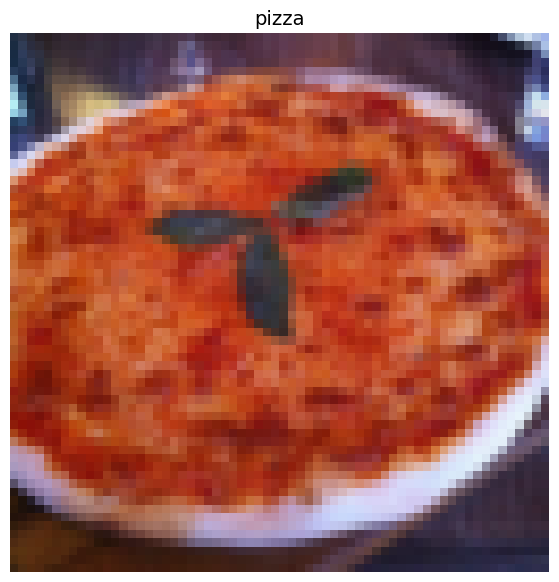

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);